In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge
import scipy.stats as stats

sns.set()
%matplotlib inline

/Users/Munoz/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3506]:
batters_df = pd.read_csv('../DEA Notebooks/cleaned_batting_years_1985_to_2017.csv')

In [3507]:
del batters_df['Unnamed: 0']

In [3508]:
batters_df.columns

Index(['ID', 'NAME', 'HEIGHT', 'WEIGHT', 'YEAR', 'AGE', 'TM', 'LG', 'G', 'PA',
       'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA',
       'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB',
       'AWARDS', 'SALARY', 'BATS_Left', 'BATS_Right', 'LG_SALARY_YEAR',
       'LG_SALARY_MEAN', 'POS_1', 'POS_2', 'POS_3', 'POS_4', 'POS_5', 'POS_6',
       'POS_7', 'POS_8', 'POS_9', 'POS_D', 'LG_MEAN_HR'],
      dtype='object')

In [3509]:


f1 = ['AGE', 'LG_SALARY_MEAN', 'BB', 'H', 'R', '2B', 'HR']  #.65 and 
f2 = ['AGE', 'OBP', 'SLG', 'HR', 'LG_SALARY_MEAN'] #.63, but coefficients make more sense
position_columns = ['POS_2', 'POS_3', 'POS_4', 'POS_5', 'POS_6',
       'POS_7', 'POS_8', 'POS_9', 'POS_D']

hr_f1 = ['WEIGHT', 'BB', 'H', 'R', '2B', '3B', 'RBI', 'BA', 'SO', 'SB']
hr_f2 = ['AGE', 'WEIGHT', 'OPS', 'R', 'OBP', 'SO']

hr_f3_no_hr_hints = ['BB', 'SO', 'SB', 'WEIGHT', '2B', '3B']

In [3510]:
subset_to_test_with = batters_df[(batters_df.PA >= 400) & (batters_df.YEAR != 1994) & (batters_df.BB < 170)]

#y_value_to_test = subset_to_test_with['HR']
y_value_to_test = np.log(subset_to_test_with['SALARY'])

subset_to_test_with.shape

(6337, 49)

In [3511]:


y = np.asarray(y_value_to_test)
features_to_test = f1
X = np.asarray(subset_to_test_with[features_to_test])

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)


In [3512]:
kf = KFold(n_splits=5, shuffle=True, random_state = 0)
lr = Lasso(alpha=0.0001)#LinearRegression()

train_scores = []
train_errors = []
coefs = []
for train_ind, val_ind in kf.split(X,y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        #print(np.argwhere(np.isnan(X_train)))
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        lr.fit(X_train_scaled, y_train)
        
        valid_set_pred = lr.predict(X_val_scaled)
        train_scores.append(lr.score(X_val_scaled, y_val))
        train_errors.append(np.sqrt(np.mean((valid_set_pred - y_val)**2)))
        coefs.append(list(zip(features_to_test, lr.coef_)))
        

In [3513]:
np.mean(train_scores)

0.59344377923525882

In [3514]:
coefs

[[('AGE', 0.75141710131311112),
  ('LG_SALARY_MEAN', 0.63232503396275841),
  ('BB', 0.13260144145537184),
  ('H', 0.26247612105462148),
  ('R', -0.025142473759162121),
  ('2B', -0.055562058702292645),
  ('HR', 0.22234938814077565)],
 [('AGE', 0.76404182181910618),
  ('LG_SALARY_MEAN', 0.61807826962237056),
  ('BB', 0.12590640347414153),
  ('H', 0.26535623248474333),
  ('R', -0.025839746668083068),
  ('2B', -0.046749416505122619),
  ('HR', 0.20858953319631016)],
 [('AGE', 0.75843513754596503),
  ('LG_SALARY_MEAN', 0.63349873299762105),
  ('BB', 0.13538548739524092),
  ('H', 0.22758709386884274),
  ('R', 0.00047726914795231468),
  ('2B', -0.04665609265062691),
  ('HR', 0.21169516355030704)],
 [('AGE', 0.7674873903784305),
  ('LG_SALARY_MEAN', 0.61330137992924449),
  ('BB', 0.12424555425792237),
  ('H', 0.2420694027577763),
  ('R', -0.0084350057702085417),
  ('2B', -0.050729771735562479),
  ('HR', 0.2102085287677305)],
 [('AGE', 0.76616879841575192),
  ('LG_SALARY_MEAN', 0.624472105192869

In [3515]:
lr = Lasso(alpha=0.00001)#LinearRegression()
train_scores = []
train_errors = []
coefs = []
for train_ind, val_ind in kf.split(X,y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        poly = PolynomialFeatures(degree=2) 

        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        
        lr.fit(X_train_poly, y_train)
        
        valid_set_pred = lr.predict(X_val_poly)
        train_scores.append(lr.score(X_val_poly, y_val))
        train_errors.append(np.sqrt(np.mean((valid_set_pred - y_val)**2)))
        coefs.append(list(zip(features_to_test, lr.coef_)))
        
        

/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [3516]:
np.mean(train_scores)

0.64649307219992092

In [3517]:
coefs

[[('AGE', 0.0),
  ('LG_SALARY_MEAN', 0.71631289379218821),
  ('BB', -0.52066329610623929),
  ('H', 0.0068293835654638819),
  ('R', 0.0050541729010236472),
  ('2B', 0.0063673733122109862),
  ('HR', -0.055810424758542615)],
 [('AGE', 0.0),
  ('LG_SALARY_MEAN', 0.64426567183525918),
  ('BB', -0.64823578039390561),
  ('H', 0.0039694106345976405),
  ('R', 0.0058383410363322813),
  ('2B', 0.0057148183470789923),
  ('HR', -0.059391340091488144)],
 [('AGE', 0.0),
  ('LG_SALARY_MEAN', 0.63520676510506258),
  ('BB', -0.53986720034318558),
  ('H', 0.010181624024842774),
  ('R', -0.00038950301174235034),
  ('2B', 0.003236194656120228),
  ('HR', -0.047684504459140589)],
 [('AGE', 0.0),
  ('LG_SALARY_MEAN', 0.64854169279886276),
  ('BB', -0.61793790967504914),
  ('H', 0.014647717150277793),
  ('R', 0.0045122375414620242),
  ('2B', -0.001047642753100469),
  ('HR', -0.058932586337964679)],
 [('AGE', 0.0),
  ('LG_SALARY_MEAN', 0.61592510265936962),
  ('BB', -0.73261011509953933),
  ('H', -0.00279007395

In [3518]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    s = len(y)
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    

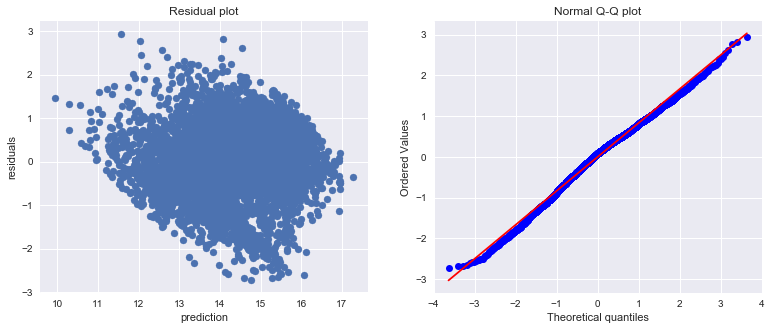

In [3519]:
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X)
#lr = LinearRegression()
#lr.fit(X_train_poly, y)
#y_pres = lr.predict()
diagnostic_plot(X_train_poly, y)

In [3520]:
model = sm.OLS(y,sm.add_constant(X))
model.data.xnames = features_to_test
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     1064.
Date:                Thu, 01 Feb 2018   Prob (F-statistic):               0.00
Time:                        21:30:24   Log-Likelihood:                -6660.2
No. Observations:                5069   AIC:                         1.334e+04
Df Residuals:                    5061   BIC:                         1.339e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
AGE               -4.4236      0.263    -16.836      0.000      -4.939      -3.909
LG_SALARY_MEAN     0.1944      0.003     58.854      0.000       0.188       0.201
BB                 0.7953      0.017     47.811      0.000       0.763       0.828
H                  0.0058      0.001      7.513      0.000       0.004       0.007
R                  0.0083      0.001      9.962      0.000       0.007       0.010
2B                -0.0007      0.001     -0.562      0.574      -0.003       0.002
HR                -0.0062      0.002     -2.855      0.004      -0.010      -0.002
==============================================================================
Omnibus:                       76.216   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.987
Skew:                          -0.233   Prob(JB):                     1.73e-15
Kurtosis:                       2.676   Cond. No.                     3.64e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [3521]:
def find_alpha():
    #X2, X2_test, y2, y2_test = train_test_split(X, y, test_size=.2, random_state=10)
    params = {
        "alpha": np.logspace(-4, -.1, 20)
    }

    grid_est = GridSearchCV(Lasso(), param_grid=params, cv=5)
    grid_est.fit(X, y)
    df = pd.DataFrame(grid_est.grid_scores_)
    df["alpha"] = df.parameters.apply(lambda val: val["alpha"])
    plt.plot(np.log(df.alpha), df.mean_validation_score);
    return grid_est.grid_scores_

/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/Munoz/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.59359, std: 0.02408, params: {'alpha': 0.0001},
 mean: 0.59359, std: 0.02408, params: {'alpha': 0.00016042171611153241},
 mean: 0.59360, std: 0.02408, params: {'alpha': 0.00025735127000169099},
 mean: 0.59360, std: 0.02408, params: {'alpha': 0.00041284732377153599},
 mean: 0.59360, std: 0.02407, params: {'alpha': 0.00066229676171483253},
 mean: 0.59360, std: 0.02407, params: {'alpha': 0.001062467830894041},
 mean: 0.59359, std: 0.02406, params: {'alpha': 0.0017044291274531946},
 mean: 0.59359, std: 0.02405, params: {'alpha': 0.0027342744561652328},
 mean: 0.59358, std: 0.02404, params: {'alpha': 0.0043863700057795363},
 mean: 0.59356, std: 0.02401, params: {'alpha': 0.0070366900382730557},
 mean: 0.59349, std: 0.02397, params: {'alpha': 0.011288378916846895},
 mean: 0.59331, std: 0.02390, params: {'alpha': 0.018109011179578204},
 mean: 0.59283, std: 0.02378, params: {'alpha': 0.029050786505108613},
 mean: 0.59159, std: 0.02361, params: {'alpha': 0.04660377025539271},
 mean: 0.

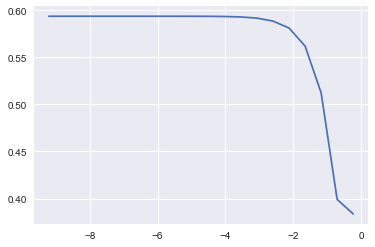

In [3522]:
find_alpha()

In [3523]:
lr = LinearRegression()
    
poly = PolynomialFeatures(degree=2) 

X_poly = poly.fit_transform(X)
X_test_poly = poly.transform(X_test)

lr.fit(X_poly, y)

test_pred_y = lr.predict(X_test_poly)

lr.score(X_test_poly, y_test)

0.66407452444491089

In [3527]:
the_list = list(zip(features_to_test, lr.coef_))
for item in the_list:
    print ('{}: {:.3f}'.format(item[0], item[1]))

AGE: 0.000
LG_SALARY_MEAN: 0.751
BB: -2.020
H: 0.002
R: 0.001
2B: 0.029
HR: -0.073
